In [1]:
import sys

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import getpass

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import bernoulli
from collections import deque # data structure to store fixed length buffers
from math import log
from numpy.linalg import norm

import random
from scipy.stats import pareto
from scipy.stats import geom


In [3]:
class SimulatorDelayedReward():

    """
    Simulator of stochastic delayed games.
  
    Params:
    -------
    MAB: list
        List of arms.

    policies: list
        List of policies to test.

    K: int
        Number of items (arms) in the pool.

    d: int
        Dimesion of the problem

    tau: integer
        Expected delay (geometric distribution)
        
    delays : an array of size T containing the independent delays
        
    timeout: integer
        longest time the learner accepts to wait for feedback
    """

    def __init__(self, theta, policies, K, d, timeout, delay_pdf, param, empirical=False):
        self.theta = theta
        self.policies = policies
        self.m = timeout
        self.d = d
        self.K = K
        self.delay_pdf = delay_pdf
        self.param = param
        self.verbose = verbose
        self.empirical=empirical
        
        print("real theta is ", self.theta)

        #self.tau_est = dict()
        
        
    def getGaussianArms(self):
        "returns K normalised vetors sampled uniformly at random in the unit ball"

        arms = np.random.multivariate_normal(np.zeros(self.d),np.identity(self.d), self.K)

        normalized_arms = arms / norm(arms, axis=1)[:,np.newaxis]

        return normalized_arms
      
    def getBernoulliArms(self):
        arms = np.random.uniform(0,1,size=(self.K,self.d))
        normalized_arms = arms / norm(arms, axis=1)[:,np.newaxis]
        return normalized_arms
      
    def getBestArm(self, arms):
        """Return the indices of the best arm"""
        means = self.getExpectedReward(arms)
        self.bestArm = np.argmax(means)
        bestReward = means[self.bestArm]
        return self.bestArm, bestReward
    
    def getExpectedReward(self,arms):
        """returns the expected payoff of the contextualized arm armIndex"""
        return np.inner(arms, self.theta)

    def play(self, arm):
        """Play arms and return the corresponding rewards """

        mean = np.dot(self.theta, arm)
        reward = bernoulli(mean).rvs()


        return reward, arm

    def run_cens(self, T, N, tsav, verbose):
        """Runs an experiment with parameters T and N.

        It returns a dictionary whose keys are policies and whose values
        are the regret obtained by these policies over the experiments and
        averaged over N runs.

        Parameters
        ----------
        T: int
            Length of the sequential allocations.

        N: int
            Number of Monte Carlo repetitions.

        q: int
            Quantile parameter (e.g. 25 -> quartiles)

        tsav: numpy array (ndim = 1)
            Points to save on each trajectory.
        """
        #Nsub = np.size(tsav)


        Nsub = np.size(tsav)    # Number of points saved for each trajectory
        #avgRegret, qRegret, QRegret = dict(), dict(), dict()
        results = dict()

        for policy in self.policies:
            name = policy.__str__()
            regret, cumRegret = np.zeros((T, N)), np.zeros((T, N))
            

            for nExp in range(N):


                if self.verbose and nExp % (N / 4) == 0:
                    print("experiments executed: %d",nExp)
                    sys.stdout.flush()


                # Reinitialize the policy 
                policy.init(self.d)
                
                if self.empirical:
                    delays = self.delay_pdf.rvs(size=T)
                else:
                    delays = self.delay_pdf.rvs(self.param,size =T).astype(int)

                disclosure = [[] for t in range(T+self.m)] #a list of size T to store delays, rewards and played vectors
                
                # Initialization

                availableArms = self.getBernoulliArms() #all arms always available

                #This would be for pseudo-regret:
                instantBestArm, instantBestReward = self.getBestArm(availableArms)

                #choose an arm uniformly at random
                chosenArm = availableArms[np.random.choice(range(self.K)),:]

                #get the feedback and update
                delay = delays[0]
                roundReward, actionPlayed = self.play(chosenArm)
                #bestDelay, bestReward, bestFeatures = self.MAB.play(instantBestArm) #get the oracle (best arm)
                #Rq : that's regret, not pseudo-regret ! We want pseudo regret

                if (roundReward != 0 and delay < self.m + 1 and 0+delay < T):
                    #display delay and associated reward to the policy
                    disclosure[delay-1].append((delay,roundReward,actionPlayed))


                regret[0,nExp] = instantBestReward - np.dot(self.theta, chosenArm) 

                policy.updateState(disclosure[0]) # empty unless delay=0


                policy.initialized = True

                # We follow the policy
                for t in range(1, T):
                    availableArms = self.getBernoulliArms() #all arms always available
                    # This would be for pseudo regret:
                    instantBestArm, instantBestReward = self.getBestArm(availableArms)

                    A_t = policy.selectArm(availableArms)

                    delay = delays[t]
                    roundReward, actionPlayed = self.play(availableArms[A_t])
                    regret[t,nExp] = instantBestReward - roundReward

                    if (roundReward != 0 and delay < self.m + 1 and t+delay < T):
                    #display delay and associated reward to the policy
                        disclosure[t+delay-1].append((delay,roundReward,actionPlayed))


                    #print(disclosure[t])
                    policy.updateState(disclosure[t])


                cumRegret[:,nExp] = np.cumsum(regret[:,nExp])

                # write a big csv table containing the results and the related infos ('timesteps', 'policy', cumregret , 'm', 'tau')
            #np.savetxt('/usr/local/google/home/vernade/Documents/figures/regret'+name+'.csv',cumRegret) #,sep=',') 
            np.savetxt('./figures/regret'+name+'.csv',cumRegret)
            results[name] = pd.DataFrame(cumRegret[tsav,:], index=tsav)
            results[name]['avg'] = np.mean(cumRegret[tsav,:],1)
            results[name]['qregret'] = np.percentile(cumRegret[tsav,:],5,1)
            results[name]['Qregret'] = np.percentile(cumRegret[tsav,:],95,1)
            
        return results
            
    def run_uncens(self, T, N, tsav, verbose):
        """Runs an experiment with parameters T and N.

        It returns a dictionary whose keys are policies and whose values
        are the regret obtained by these policies over the experiments and
        averaged over N runs.

        Parameters
        ----------
        T: int
            Length of the sequential allocations.

        N: int
            Number of Monte Carlo repetitions.

        q: int
            Quantile parameter (e.g. 25 -> quartiles)

        tsav: numpy array (ndim = 1)
            Points to save on each trajectory.
        """
        #Nsub = np.size(tsav)


        Nsub = np.size(tsav)    # Number of points saved for each trajectory
        #avgRegret, qRegret, QRegret = dict(), dict(), dict()
        results = dict()

        for policy in self.policies:
            name = policy.__str__()
            regret, cumRegret = np.zeros((T, N)), np.zeros((T, N))
            

            for nExp in range(N):

                if self.verbose and nExp % (N / 4) == 0:
                    print("experiments executed: %d",nExp)
                    sys.stdout.flush()
                    
                if self.empirical:
                    delays = self.delay_pdf.rvs(size=T)
                else:
                    delays = self.delay_pdf.rvs(self.param,size =T).astype(int)


                # Reinitialize the policy 
                policy.init(self.d)
                

                disclosure = [[] for t in range(T)] #a list of size T to store delays, rewards and played vectors
                
                # Initialization

                availableArms = self.getBernoulliArms() #all arms always available

                #This would be for pseudo-regret:
                instantBestArm, instantBestReward = self.getBestArm(availableArms)

                #choose an arm uniformly at random
                chosenArm = availableArms[np.random.choice(range(self.K)),:]

                #get the feedback and update
                delay = delays[0]
                roundReward, actionPlayed = self.play(chosenArm)
                #bestDelay, bestReward, bestFeatures = self.MAB.play(instantBestArm) #get the oracle (best arm)
                #Rq : that's regret, not pseudo-regret ! We want pseudo regret

                if (roundReward != 0 and 0+delay <T ):
                    #display delay and associated reward to the policy
                    disclosure[delay-1].append((delay,roundReward,actionPlayed))


                regret[0,nExp] = instantBestReward - np.dot(self.theta, chosenArm) 

                policy.updateState(disclosure[0]) # empty unless delay=0

                policy.initialized = True

                # We follow the policy
                for t in range(1, T):

                    availableArms = self.getBernoulliArms() #all arms always available
                    # This would be for pseudo regret:
                    instantBestArm, instantBestReward = self.getBestArm(availableArms)

                    A_t = policy.selectArm(availableArms)


                    delay = delays[t]
                    roundReward, actionPlayed = self.play(availableArms[A_t])
                    regret[t,nExp] = instantBestReward - roundReward

                    if (roundReward != 0 and t+delay <T):
                    #display delay and associated reward to the policy
                        disclosure[t+delay-1].append((delay,roundReward,actionPlayed))


                    #print(disclosure[t])
                    policy.updateState(disclosure[t])


                cumRegret[:,nExp] = np.cumsum(regret[:,nExp])

                # write a big csv table containing the results and the related infos ('timesteps', 'policy', cumregret , 'm', 'tau')
            #np.savetxt('/usr/local/google/home/vernade/Documents/figures/regret'+name+'.csv',cumRegret) #,sep=',') 
            np.savetxt('./figures/regret'+name+'.csv',cumRegret) #,sep=',') 

            results[name] = pd.DataFrame(cumRegret[tsav,:], index=tsav)
            results[name]['avg'] = np.mean(cumRegret[tsav,:],1)
            results[name]['qregret'] = np.percentile(cumRegret[tsav,:],5,1)
            results[name]['Qregret'] = np.percentile(cumRegret[tsav,:],95,1)

#         print("build data out of the experiments")
#         for policy in self.policies:
#             name = policy.__str__()
            
#             cumReg = cumRegret[name]
#             avgRegret[name] = np.mean(cumReg, 0)
#             qRegret[name] = np.percentile(cumReg, q, 0)
#             QRegret[name] = np.percentile(cumReg, 100 - q, 0)

        return results
 
        #return regret #, avgRegret, qRegret, QRegret


In [2]:
# @title DeLinUCB

from numpy.linalg import pinv
#use buffer to store last 'threshold' actions
from collections import deque

class Policy(object):

    def __init__(self, K, T):
        """
        Constructor.
        """
        raise NotImplementedError("Method `__init__` is not implemented.")

    def selectArms(self):
        """
        This functions selects L arms among the K ones depending on statistics
        over the past observations.
        """
        raise NotImplementedError("Method `selectArms` is not implemented.")

    def updateState(self):
        """
        This function updates the statistics given the new observations.
        """
        raise NotImplementedError("Method `updateState` is not implemented.")

    #@staticmethod
    def id(self):
        raise NotImplementedError("Static method `id` is not implemented.")

    @staticmethod
    def recquiresInit():
        raise NotImplementedError("Static method `recquiresInit` is not \
                                   implemented.")




class PolicyDeLinUCB(Policy):

    def __init__(self, T, m, lamba_reg , delta, alpha, bias_term=True):

        self.m = m
        self.alpha = alpha
        self.delta = delta
        self.lambda_reg = lambda_reg
        self.initialized = False
        self.bias_term = bias_term
        #self.Delta = 1
        #dropping the loglog(t) term for now



    def selectArm(self,arms):
        """
        This function implements the randomized LinUCB algorithm in delayed environment.
        It discards all observations received within the last m time steps.
        Input:
        -------
        arms : (K x d) array containing K arms in dimension d

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
        if not self.initialized:
            return None     # Better raise error

        K = len(arms)
        self.UCBs = np.zeros(K)
        
        for i in range(K):
            a = arms[i,:]
            covxa = np.inner(self.invcov,a.T)
            
            if self.bias_term:
                self.UCBs[i] = np.dot(self.hat_theta,a) \
                                + self.alpha \
                                * (np.sqrt(self.beta[self.t-1] + self.lambda_reg) + np.sum(self.bias)) \
                                * (np.dot(a,covxa)) 
            else:
              # neglecting the bias term (wrong confidence regions)
                self.UCBs[i] = np.dot(self.hat_theta,a) \
                                + self.alpha * (np.sqrt(self.beta[self.t-1]+ np.sqrt(self.lambda_reg)) * (np.dot(a,covxa)))
            
        
        #print(self.bias)
        #print(np.sum(self.bias))
        #print(self.UCBs)
        mixer = np.random.random(self.UCBs.size) # Shuffle to avoid always pulling the same arm when ties
        UCB_indices = list(np.lexsort((mixer,self.UCBs))) # Sort the indices
        output = UCB_indices[::-1]              # Reverse list
        chosen_arm = output[0]
        
        #bias update (exact elliptical norm)
        A_norm = np.dot(arms[chosen_arm,:],np.inner(self.invcov,arms[chosen_arm,:].T))
        self.bias.append(A_norm) #automatically remove overflow
        
        xxt = np.outer(arms[chosen_arm,:],arms[chosen_arm,:].T)
        self.cov += xxt
        self.invcov = pinv(self.cov)
        #self.Delta = min(self.m, self.Delta +1)

        return chosen_arm


        
    def updateState(self, disclosure):
        "disclosure is a list of T lists containing all data to be displayed at time t"

        for feedback in disclosure: 
            delay, reward, features = feedback
            self.xy += reward * features

            
        self.hat_theta = np.inner(self.invcov,self.xy)
        self.t += 1

    def init(self, dim):

        self.t = 0
        self.dim = dim
        self.hat_theta = np.zeros(self.dim)
        self.cov = self.lambda_reg * np.identity(self.dim)
        self.invcov = np.identity(self.dim)
        self.bias = deque(maxlen=self.m) #buffer of size m
        self.xy = np.zeros(self.dim)     
        self.beta = [2 * log(1/self.delta) + self.dim * (log(1+t  / (self.lambda_reg * self.dim)))  for t in range(1,T)] 


    def __str__(self):
        if self.bias_term:
            
            return 'OTFLinUCB'
        else:
            return 'OTFLinUCB-wrong'

    @staticmethod
    def id():
        return 'OTFLinUCB'

    @staticmethod
    def recquiresInit():
        return True
 

In [4]:
# @title DeLinTS

class PolicyDeLinTS(Policy):

    def __init__(self, T, m, sigma_0):

        self.m = m
        self.sigma_0 = sigma_0
        self.Delta = 1 # missing observations m - nb already received obs
        

    def selectArm(self,arms):
        """
        LinTS with approximate prior including an upper bound on the extra variance coming from the delays
        Input:
        -------
        arms : list of objects Arm with contextualized features

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
        K = len(arms)
        
        theta_tilde = np.random.multivariate_normal(self.hat_theta,  self.invcov) 
        #print(theta_tilde)
        estimated_means = np.zeros(K)
        
        for i in range(K):
            a = arms[i,:]
            estimated_means[i] = np.dot(theta_tilde.T, a)
        
        #print(estimated_means)
        chosen_arm = np.argmax(estimated_means)
        
        xxt = np.outer(arms[chosen_arm,:],arms[chosen_arm,:].T)
        self.cov += xxt
        self.invcov = pinv((self.sigma_0 + np.sum(self.bias)) * self.cov)
        #self.Delta = min(self.Delta+1,self.m)
        #print(self.Delta)
        
        
        #bias update (exact elliptical norm)
        A_norm = np.dot(arms[chosen_arm,:],np.inner(self.invcov,arms[chosen_arm,:].T))
        self.bias.append(A_norm)
        
        return chosen_arm


        
    def updateState(self, disclosure):
        "disclosure is a list of T lists containing all data to be displayed at time t"

        for feedback in disclosure: 
            delay, reward, features = feedback
            self.xy += reward * features

            
        self.hat_theta = np.inner(self.invcov,self.xy)
        self.t += 1

    def init(self, dim):
        
        self.t = 0
        self.dim = dim
        self.hat_theta = np.zeros(self.dim)
        # the regularization is increased by the equivalent of m/lambda to cover for the additive variance due to the delays
        self.cov = (self.sigma_0 **2) *  np.identity(self.dim)
        self.invcov = np.identity(self.dim)
        self.bias = deque(maxlen=self.m)
        self.xy = np.zeros(self.dim) 
       

    def __str__(self):         
            return 'OTFLinTS'


    @staticmethod
    def id():
        return 'OTFLinTS'

    @staticmethod
    def recquiresInit():
        return True

In [7]:

colors = sns.color_palette()


def plot_regret(results,fname='cumreg'):
 
  plt.figure()
  plt_num = 0
  
  for policy in results.keys():
      name = policy
      df = results[name]

      plt.plot(df.index, df.avg, color=colors[plt_num], label=name)
      plt.fill_between(df.index, df.qregret,  df.Qregret,alpha=0.2, color=colors[plt_num])
      
      plt_num+=1
  plt.legend(loc=4)
  plt.ylabel('cumulative regret')
  plt.xlabel('time steps')
  plt.savefig('./figures/'+fname+'.pdf') # your local directory
  plt.show()
                       

    
#     df = results['OTFLinUCB']
# df['mean'] = df.apply(np.mean)

# from colabtools import adhoc_import
# regret_plot = (gg.ggplot(results['OTFLinUCB'])
#                  +gg.aes(x=df.index, y='mean') #, colour='policy')
#                  +gg.geom_smooth(method=smoothers.median, span=0.1, level=0.95)
#                  +gg.labs(y='Cumlative expected regret')
#                 )
  
# print(regret_plot)

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


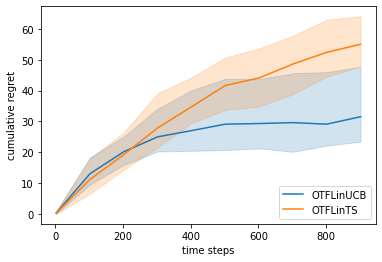

In [9]:
# debug run

d = 5         # dimension
K = 7

theta = np.ones(d) #np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)

# Confidence shrinkage (unfair comparison with TS if <1)
alpha = 1.

T = 1000        # Finite Horizon
N = 5        # Monte Carlo simulations

delta = 0.1
lambda_reg = 1.


# save subsampled points for Figures
Nsub = 100
tsav = range(2,T,Nsub)
L = len(tsav)

verbose = False

# choice of delay distribution
delay_pdf = geom
#delay_pdf = pareto
  

## PARAMETERS
tau = 5
timeout = 10
    
# Policies to evaluate
policies = [
            PolicyDeLinUCB(T, timeout, lambda_reg, delta, alpha, bias_term=True),
            PolicyDeLinTS(T,timeout, 1)]

simulator = SimulatorDelayedReward(theta, policies, K, d, timeout, delay_pdf, 1/tau)  
results = simulator.run_cens(T, N, tsav, verbose)

plot_regret(results)


In [10]:
# @title WaitingLinUCB

class PolicyWaitingUCB(Policy):
    """
    This Policy does not update its internal parameters within the timeout window. 
    This is to avoid local biases in the estimation due to early rewards for some actions. 
    It maintains an internal disclosure buffer that stores the rewards to be disclosed at each round 
    """

    def __init__(self, T, m, lambda_reg, delta, alpha):

        self.m = m
        self.delta = delta
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        self.initialized = False
        self.actions_played ={}


    def selectArm(self,arms):
        """
        This function implements the randomized LinUCB algorithm in delayed environment.
        It discards all observations received within the last thr time steps.
        Input:
        -------
        arms : list of objects Arm with contextualized features

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
        if not self.initialized:
            return None     # Better raise error

        K = len(arms)
        self.UCBs = np.zeros(K)
        
        for i in range(K):
            a = arms[i,:]
            covxa = np.inner(self.invcov,a.T)
            self.UCBs[i] = np.dot(self.hat_theta,a) + self.alpha * (np.sqrt(self.beta[self.t-1]+ np.sqrt(self.lambda_reg)) * (np.dot(a,covxa)))
  
        mixer = np.random.random(self.UCBs.size) # Shuffle to avoid always pulling the same arm when ties
        UCB_indices = list(np.lexsort((mixer,self.UCBs))) # Sort the indices
        output = UCB_indices[::-1]              # Reverse list
        chosen_arm = output[0]
        
        self.actions_played[self.t]=arms[chosen_arm,:]
        
        if self.t > self.m:
            xxt = np.outer(self.actions_played[self.t-self.m],self.actions_played[self.t-self.m].T)
            self.cov += xxt
            self.invcov = pinv(self.cov)
        
        return chosen_arm
       
        
    def updateState(self, disclosure):
        "disclosure is a list of T lists containing all data to be displayed at time t"

        for feedback in disclosure: 
            delay, reward, features = feedback
            # append this feedback self.to time steps after the action actually occurred (self.t - delay )
            self.internalDisclosure[self.t - delay + self.m ].append((delay,reward,features))
            
        if self.t >= self.m:
            """start updating only when the first timeout steps are over"""
            for feedback in self.internalDisclosure[self.t]:
                delay, reward, features = feedback
                self.xy += reward * features

        self.hat_theta = np.inner(self.invcov,self.xy)
        self.t += 1

    def init(self, dim):

        self.t = 0
        self.dim = dim
        self.hat_theta = np.zeros(self.dim)
        self.internalDisclosure = [[] for t in range(T+self.m)]
        self.cov = self.lambda_reg * np.identity(self.dim)
        self.invcov = np.identity(self.dim)
        self.xy = np.zeros(self.dim)    
        self.beta = [2 * log(1/self.delta) + self.dim * (log(1+t  / (self.lambda_reg * self.dim)))  for t in range(1,T)] 


    def __str__(self):
        return 'WaiLinUCB'
        #return 'UCB policy for delayed MAB that discards most recent observations'

    @staticmethod
    def id():
        return 'WaiLinUCB'

    @staticmethod
    def recquiresInit():
        return True

In [11]:
#@title WaitingLinTS

class PolicyWaitingTS(Policy):
    """
    This Policy does not update its internal parameters within the timeout window. 
    This is to avoid local biases in the estimation due to early rewards for some actions. 
    It maintains an internal disclosure buffer that stores the rewards to be disclosed at each round 
    """

    def __init__(self, T, timeout, sigma_0, sigma):

        self.m = timeout
        self.sigma_0 = sigma_0 # prior variance
        self.sigma = sigma # noise variance assumption
        self.actions_played ={}


    def selectArm(self,arms):
        """
        This function implements the randomized LinTS algorithm in delayed environment.
        It discards all observations received within the last timeout time steps.
        Input:
        -------
        arms : list of objects Arm with contextualized features

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
        K = len(arms)
        theta_tilde = np.random.multivariate_normal(self.hat_theta, self.sigma**2 * self.invcov) 
        #print(theta_tilde)
        estimated_means = np.zeros(K)
        
        for i in range(K):
            a = arms[i,:]
            estimated_means[i] = np.dot(theta_tilde.T, a)
        
        #print(estimated_means)
        chosen_arm = np.argmax(estimated_means)
        
        self.actions_played[self.t]=arms[chosen_arm,:]
        
        if self.t > self.m:
            xxt = np.outer(self.actions_played[self.t-self.m],self.actions_played[self.t-self.m].T)
            self.cov += xxt
            self.invcov = pinv(self.cov)
        
        return chosen_arm
       
        
    def updateState(self, disclosure):
        "disclosure is a list of T lists containing all data to be displayed at time t"

        for feedback in disclosure: 
            delay, reward, features = feedback
            # append this feedback self.to time steps after the action actually occurred (self.t - delay )
            self.internalDisclosure[self.t - delay + self.m ].append((delay,reward,features))
            
        if self.t >= self.m:
            """start updating only when the first timeout steps are over"""
            for feedback in self.internalDisclosure[self.t]:
                delay, reward, features = feedback
                self.xy += reward * features

        self.hat_theta = np.inner(self.invcov,self.xy)
        self.t += 1

    def init(self, dim):

        self.t = 0
        self.dim = dim
        self.hat_theta = np.zeros(self.dim)
        self.internalDisclosure = [[] for t in range(T+self.m)]
        self.cov = np.identity(self.dim) * self.sigma**2 / self.sigma_0**2
        self.invcov = np.identity(self.dim) * self.sigma_0**2 / self.sigma**2
        self.xy = np.zeros(self.dim)     # Rewards a every position


    def __str__(self):
        return 'WaiLinTS'

    @staticmethod
    def id():
        return 'WaiLinTS'

    @staticmethod
    def recquiresInit():
        return True

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


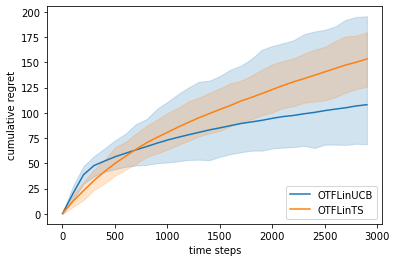

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


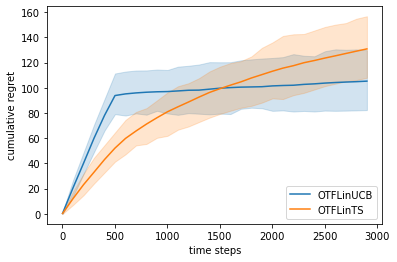

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


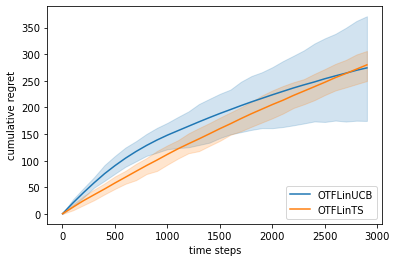

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


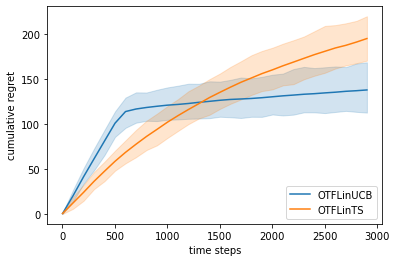

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


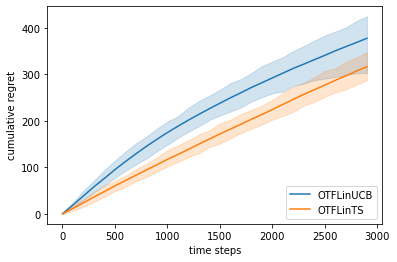

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


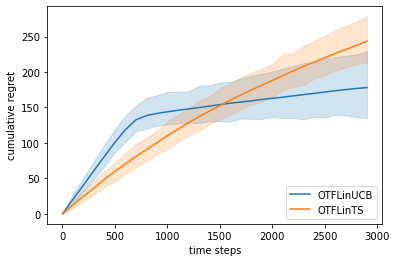

In [12]:
# @title Paper realistic simulation


d = 5         # dimension
K = 10

theta = np.ones(d) #np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)

# Confidence shrinkage (unfair comparison with TS if <1)
alpha = 1.

T = 3000         # Finite Horizon
N = 100         # Monte Carlo simulations

delta = 0.1
lambda_reg = 1.


# save subsampled points for Figures
Nsub = 100
tsav = range(2,T,Nsub)
L = len(tsav)

verbose = True

# choice of delay distribution
delay_pdf = geom
#delay_pdf = pareto
  

## PARAMETERS
tau_list = [100,500,1000] # Averaged delay (geometric law)
timeout_list = [100,500] # limit for accepting observations


for tau in tau_list:
    for timeout in timeout_list:
    
        # Policies to evaluate
        policies = [ PolicyDeLinUCB(T, timeout, lambda_reg, delta, alpha, bias_term=True),
                    PolicyDeLinTS(T, timeout, 0.5)]

        simulator = SimulatorDelayedReward(theta, policies, K, d, timeout, delay_pdf, 1/tau)  
        results_cens = simulator.run_cens(T, N, tsav, verbose)
        #results_uncens = simulator.run_uncens(T, N, tsav, verbose)


        plot_regret(results_cens,fname='cumreg_cens_N_'+str(N)+'_tau'+str(tau)+'_timeout'+str(timeout))
        #plot_regret(results_uncens,fname='cumreg_uncens_N_'+str(N)+'_tau'+str(tau)+'_timeout'+str(timeout))
    


#with open('delinucb-waitlinucb_cens_'+str(cens)+'_noise-'+noise+'_tau'+str(tau)+'_timeout'+str(timeout)+'.pkl', 'wb') as foutput:
#    pickle.dump(data, foutput, protocol=2)

#plot_regret(data, tsav, "delinucb-waitlinucb_cens_"+str(cens)+"_noise-"+noise+"_tau"+str(tau)+"_timeout"+str(timeout), log=False,  qtl=True)        

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


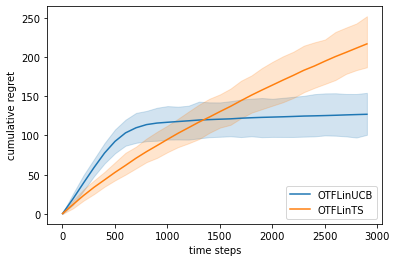

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


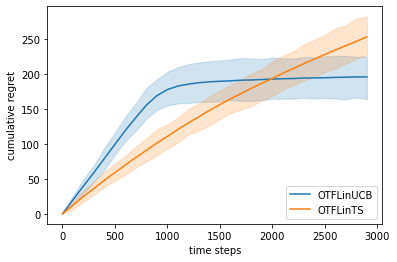

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


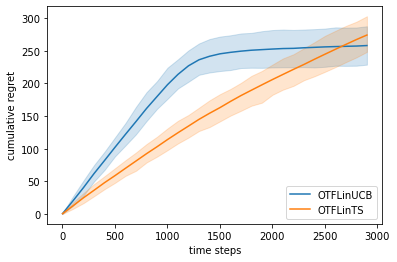

In [20]:
d = 5         # dimension
K = 10

theta = np.ones(d) #np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)

# Confidence shrinkage (unfair comparison with TS if <1)
alpha = 1.

T = 3000         # Finite Horizon
N = 100         # Monte Carlo simulations

delta = 0.1
lambda_reg = 1.


# save subsampled points for Figures
Nsub = 100
tsav = range(2,T,Nsub)
L = len(tsav)

verbose = True

# choice of delay distribution
delay_pdf = geom
#delay_pdf = pareto
## PARAMETERS
tau_list = [100,500,1000] # Averaged delay (geometric law)
#timeout_list = [100,500] # limit for accepting observations
timeout=3000

for tau in tau_list:
#for timeout in timeout_list:
    
        # Policies to evaluate
        policies = [ PolicyDeLinUCB(T, timeout, lambda_reg, delta, alpha, bias_term=True),
                    PolicyDeLinTS(T, timeout, 0.5)]

        simulator = SimulatorDelayedReward(theta, policies, K, d, timeout, delay_pdf, 1/tau)  
        results_cens = simulator.run_cens(T, N, tsav, verbose)
        #results_uncens = simulator.run_uncens(T, N, tsav, verbose)


        plot_regret(results_cens,fname='cumreg_cens_N_'+str(N)+'_tau'+str(tau)+'_timeout'+str(timeout))
        #plot_regret(results_uncens,fname='cumreg_uncens_N_'+str(N)+'_tau'+str(tau)+'_timeout'+str(timeout))
    

In [21]:
# @title Testing the dependency on m -- the censoring window or bound on expectation

## PARAMETERS

d = 5         # dimension
K = 7

theta = np.ones(d) #np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)

# Confidence shrinkage (unfair comparison with TS if <1)
alpha = 1.

T = 1000         # Finite Horizon
N = 10         # Monte Carlo simulations

delta = 0.1
lambda_reg = 1.

# save subsampled points for Figures
Nsub = 100
tsav = range(2,T,Nsub)
L = len(tsav)
end = tsav[-1]
verbose = False

timeout_list = np.arange(100,1000,50) # limit for accepting observations
cens = 'uncensored'

m_exp = pd.DataFrame(index=['OTFLinUCB', 'OTFLinTS'])

# choice of delay distribution
delay_pdf=geom
inv_mean = 1/200

#delay_pdf = pareto
#b_pareto = 0.5

for timeout in timeout_list:
    
    timeout = int(timeout)
    # Policies to evaluate
    policies = [
                PolicyDeLinUCB(T, timeout, lambda_reg, delta, alpha, bias_term=True),
                PolicyDeLinTS(T, timeout, 0.5)]
    
    simulator = SimulatorDelayedReward(theta, policies, K, d, timeout, delay_pdf, inv_mean)  
    results = simulator.run_cens(T, N, tsav, verbose)

    m_exp[str(timeout)]= np.array([results['OTFLinUCB'].at[end,'avg'], results['OTFLinTS'].at[end,'avg']])
 

    

real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472

In [22]:
rv = geom(0.002)
1/rv.cdf(100)

5.511670553355557

<AxesSubplot:>

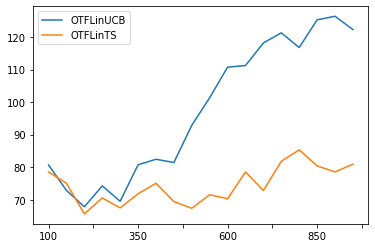

In [23]:
# @title Our experiments tends to show that m should not have an impact on the regret
m_exp=m_exp.T
m_exp.plot()

# Heavy-tailed delays

We extracted delay information from the dataset of Diemert, Meynet et al. 2017 (https://ailab.criteo.com/criteo-attribution-modeling-bidding-dataset/), see the dedicated notebook for details.
Here, we retrieve the empirical distribution of the delays and simulate a linear bandits experiment with the realistic delays.


In [24]:
log_delay_values = pd.read_csv('./figures/emp_dist_delay_log_values', header=None) # your local directory, where the files from the real data analysis notebook were saved
probabilities = pd.read_csv('./figures/emp_dist_delay', header = None)

log_delay_values.head()

,0
0,0.000000
1,0.006414
2,0.012827
3,0.019241
4,0.025655


In [25]:
delay_values = log_delay_values.apply(lambda x: 10**x)
delay_values.head()
delay_values.tail()



,0
996,2.443318e+06
997,2.479668e+06
998,2.516560e+06
999,2.554000e+06
1000,2.591997e+06


In [26]:
delays =delay_values.iloc[:].values.squeeze().astype(int)
probs = probabilities.iloc[:].values.squeeze()
probs = probs/np.sum(probs)
print(probs.sum())
print(delays.sum())

delays = delays/100 # rescaling for experiment
cdf = np.cumsum(probs)


1.0000000000000002
176813770


In [27]:
class empirical_sampler(): 
  def __init__(self, delays, probs):
    self.delays = delays
    self.probs = probs
  def rvs(self, size):
    return np.random.choice(a=self.delays,p=self.probs, size =size)

In [28]:
emp_pdf =empirical_sampler(delays.astype(int), probs)
test = emp_pdf.rvs(size=10000)
np.sum(test>1000)

6260

tau_m is 0.4473490264362539
real theta is  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75
experiments executed: %d 0
experiments executed: %d 25
experiments executed: %d 50
experiments executed: %d 75


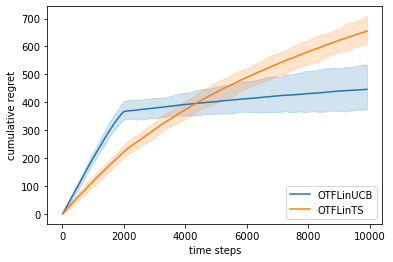

In [29]:
## PARAMETERS

d = 5         # dimension
K = 10

theta = np.ones(d) #np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)

# Confidence shrinkage (unfair comparison with TS if <1)
alpha = 1.

T = 10000         # Finite Horizon
N = 100         # Monte Carlo simulations

delta = 0.1
lambda_reg = 1.

# save subsampled points for Figures
Nsub = 100
tsav = range(2,T,Nsub)
L = len(tsav)

verbose = True

timeout_list = [2000] # limit for accepting observations

for timeout in timeout_list:
  
  #evaluate tau_m:
  bin_m = np.sum(delays<timeout)
  
  print('tau_m is '+ str(cdf[bin_m]))
  
  
  policies = [
              PolicyDeLinUCB(T, timeout, lambda_reg, delta, alpha, bias_term=True),
              PolicyDeLinTS(T,timeout, 1)]

  simulator = SimulatorDelayedReward(theta, policies, K, d, timeout, emp_pdf, 1, empirical=True)  
  
  results_cens = simulator.run_cens(T, N, tsav, verbose)

  plot_regret(results_cens,fname='cumreg_real_cens_N_'+str(N)+'_tau'+str(tau)+'_timeout'+str(timeout))
  

